# IE 421 Data Wizards of Gandalf / Beyond the Medal

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

In [2]:
dff = pd.read_csv('paris2024_athletes.csv')
dff.head

<bound method NDFrame.head of                     name  gender   nationality_long    disciplines
0       ALEKSANYAN Artur    Male            Armenia  ['Wrestling']
1         AMOYAN Malkhas    Male            Armenia  ['Wrestling']
2        GALSTYAN Slavik    Male            Armenia  ['Wrestling']
3      HARUTYUNYAN Arsen    Male            Armenia  ['Wrestling']
4        TEVANYAN Vazgen    Male            Armenia  ['Wrestling']
...                  ...     ...                ...            ...
11108     ADA ETO Sefora  Female  Equatorial Guinea  ['Athletics']
11109    LIUZZI Emanuela  Female                NaN  ['Wrestling']
11110       BOERS Isayah    Male        Netherlands    [Athletics]
11111        STAUT Kevin    Male             France   [Equestrian]
11112    CARVELL Charlie    Male      Great Britain    [Athletics]

[11113 rows x 4 columns]>

In [3]:
dff.isnull().sum()

name                0
gender              0
nationality_long    3
disciplines         0
dtype: int64

In [4]:
df = dff.dropna()

In [5]:
df.head()

,name,gender,nationality_long,disciplines
0,ALEKSANYAN Artur,Male,Armenia,['Wrestling']
1,AMOYAN Malkhas,Male,Armenia,['Wrestling']
2,GALSTYAN Slavik,Male,Armenia,['Wrestling']
3,HARUTYUNYAN Arsen,Male,Armenia,['Wrestling']
4,TEVANYAN Vazgen,Male,Armenia,['Wrestling']


In [6]:
df.isnull().sum()

name                0
gender              0
nationality_long    0
disciplines         0
dtype: int64

In [7]:
df.describe()

,name,gender,nationality_long,disciplines
count,11110,11110,11110,11110
unique,11100,2,197,52
top,PORTELA Teresa,Male,United States of America,['Athletics']
freq,2,5657,696,2018


In [8]:
# Calculate male-to-female ratio
df.loc[:, 'gender_count'] = df.groupby(['disciplines', 'nationality_long', 'gender'])['gender'].transform('count')

# Create pivot table
gender_pivot = df.pivot_table(index=['disciplines', 'nationality_long'], 
                              columns='gender', 
                              values='gender_count', 
                              fill_value=0).reset_index()

# Calculate the male-to-female ratio
gender_pivot['male_to_female_ratio'] = gender_pivot['Male'] / (gender_pivot['Female'] + 1e-6)  # Avoid division by zero

# Label the data as "gender-equal" or "gender-unequal" (Target variable)
threshold = 1.1  # Define what ratio qualifies as gender equality
gender_pivot['target'] = np.where((gender_pivot['male_to_female_ratio'] >= 1/threshold) & 
                                  (gender_pivot['male_to_female_ratio'] <= threshold), 1, 0)

C:\Users\ilayd\AppData\Local\Temp\ipykernel_15628\1738460466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'gender_count'] = df.groupby(['disciplines', 'nationality_long', 'gender'])['gender'].transform('count')


In [9]:
df_merged= df.merge(gender_pivot, on= ['disciplines', 'nationality_long'])

In [10]:
# Encode categorical variables (nationality_long and disciplines)
encoder = OneHotEncoder(drop='first')  # drop='first' to avoid multicollinearity
encoded_features = encoder.fit_transform(df[['nationality_long', 'disciplines']])

In [11]:
# Create a DataFrame for encoded features
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(['nationality_long', 'disciplines']))

In [12]:
# Combine encoded features with the original dataset
X = encoded_df  # Features
y= df_merged['target']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Classification

In [14]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [15]:
# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

In [17]:
# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model Evaluation:
Accuracy: 0.7929792979297929

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1538
           1       0.71      0.56      0.62       684

    accuracy                           0.79      2222
   macro avg       0.76      0.73      0.74      2222
weighted avg       0.79      0.79      0.79      2222


Confusion Matrix:
[[1380  158]
 [ 302  382]]


In [18]:
# Feature Importance Analysis
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print("\nFeature Importance:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))


Feature Importance:
                                Feature  Importance
200           disciplines_['Athletics']    0.038006
235            disciplines_['Swimming']    0.027440
217          disciplines_['Equestrian']    0.020596
204              disciplines_['Boxing']    0.019011
244           disciplines_['Wrestling']    0.017494
..                                  ...         ...
162    nationality_long_Solomon Islands    0.000070
75               nationality_long_Haiti    0.000068
23   nationality_long_Brunei Darussalam    0.000060
16              nationality_long_Belize    0.000055
246            disciplines_[Equestrian]    0.000000

[247 rows x 2 columns]


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1538
           1       0.71      0.56      0.62       684

    accuracy                           0.79      2222
   macro avg       0.76      0.73      0.74      2222
weighted avg       0.79      0.79      0.79      2222



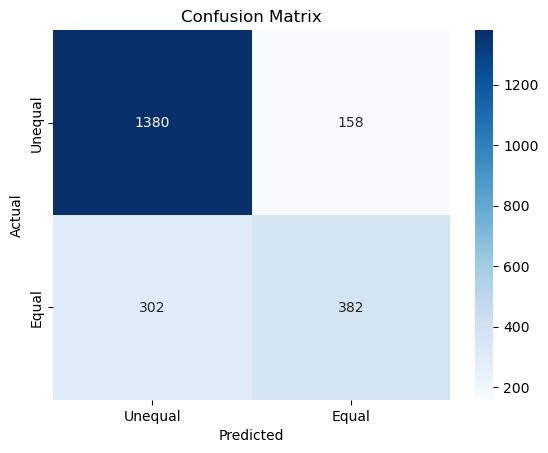

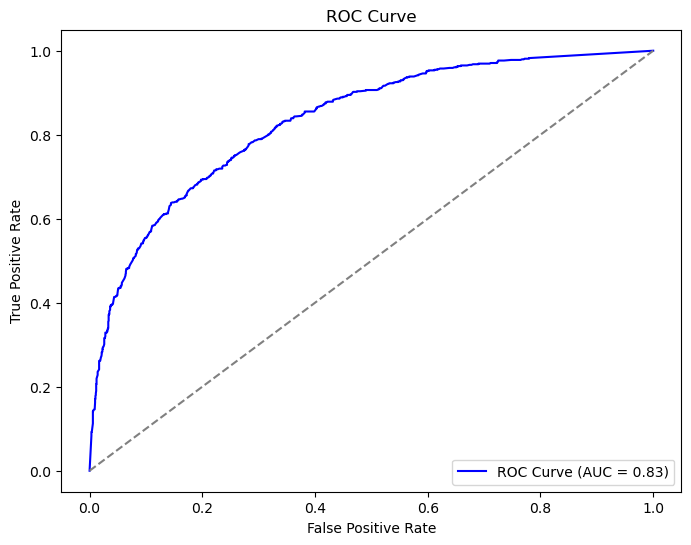

In [19]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Unequal', 'Equal'], yticklabels=['Unequal', 'Equal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()